# ip_device_os別のクリック数を1分単位で集計した
---
- 分間クリック数は最大で2180
- OverallのDL率0.24%に対し，分間クリック数1: 1.70%, 2: 0.50%, 3: 0.25%
- ~~分間クリック数4回からはDL率がOverallを下回るが，徐々にDL率のばらつきが大きくなり，分間400回を超えたあたりからOverallのDL率を上回るものがでてくる~~
  - ~~それっぽい確率でダウンロードまで実行するbotが存在する？~~
  - ~~分間数十回以上の場合には，ip_device_osごとにDLありのbotかDLなしのbotかを識別する，とかできそう．~~
  - そもそも分間クリック数83回以上みたいなケースが少ないので，可視化するとDL率が高く見えるだけっぽい
  - 分間クリック数83回以上のダウンロード率は0.065%
  - 分間クリック数13回以上のダウンロード率が0.060%
- ある分間クリック数以上はnaiveな手法で確率を割り当て，モデリング対象から外すとする．このとき，モデリング対象となるレコードは全DL回数の何%をカバーできるか
  - 分間83回クリックまでモデリングするとattributionの99%をカバーでき，レコード数は700万程度削れる
  - 分間21回クリックまでモデリングするとattributionの95%をカバーでき，レコード数は4000万程度削れる
  - 分間12回クリックまでモデリングするとattributionの90%をカバーでき，レコード数は7500万程度削れる
    - 1位が0.98台に落ち着きそうな雰囲気なので，5%のダウンロードに対してnaiveな手法を採ってしまうと勝てなさそう．
    - 分間クリック数の多寡で2分して別々のモデルを構築する，もしくは単に特徴量に加えるのがいいか？

In [128]:
import psycopg2
import json
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [8]:
with open("../config.json") as f:
    connection = psycopg2.connect(**json.load(f))

cur = connection.cursor()
connection.get_backend_pid()

10816

In [13]:
cur.execute('select relname from pg_stat_user_tables;')
cur.fetchall()

[('click_data',),
 ('ip_device_os_dow',),
 ('ip_device_os_dow_hour_min',),
 ('ip_device_os',),
 ('summarize_by_idodhm',),
 ('ip_device_os_dow_hour',)]

In [18]:
query="""
SELECT * 
FROM summarize_by_idodhm
;
"""
df = pd.read_sql(sql=query, con=connection)
df.head()

,ip_device_os_dow_hour_min,count_click,count_attrib,flag_attrib
0,1.000100e+12,1,0,False
1,1.000100e+12,1,0,False
2,1.000100e+12,1,0,False
3,1.000100e+12,1,0,False
4,1.000100e+12,1,0,False


In [19]:
df.count_click.max()

2180

In [109]:
s = df
s["idx"] = s.count_click.values

In [164]:
df_grp = s.groupby("idx", as_index=False)
df_agg = pd.DataFrame()
df_agg["count_click"] = df_grp.agg({"count_click": "count"}).idx.values
df_agg["frequency"] = df_grp.agg({"count_click": "count"}).count_click.values
df_agg["cum_frequency"] = df_agg.frequency.cumsum()
df_agg["total_click"] = df_grp.agg({"count_click": "sum"}).count_click.values
df_agg["cum_total_click"] = df_agg.total_click.cumsum()
df_agg["total_attrib"] = df_grp.agg({"count_attrib": "sum"}).count_attrib.values
df_agg["rate_attrib"] = df_agg.total_attrib / df_agg.total_click
df_agg["cum_total_attrib"] = df_agg.total_attrib.cumsum()
df_agg["cump_total_attrib"] = df_agg.total_attrib.cumsum() / s.count_attrib.sum()
df_agg

,count_click,frequency,cum_frequency,total_click,cum_total_click,total_attrib,rate_attrib,cum_total_attrib,cump_total_attrib
0,1,14290868,14290868,14290868,14290868,242521,0.016970347777335849,242521,0.530859414332181978
1,2,7636461,21927329,15272922,29563790,75187,0.004922895566414861,317708,0.695437849953813747
2,3,4022235,25949564,12066705,41630495,30163,0.002499688191598286,347871,0.761462287072667832
3,4,2856471,28806035,11425884,53056379,16807,0.001470958395866788,364678,0.798251489561033645
4,5,1730901,30536936,8654505,61710884,10639,0.001229301964699310,375317,0.821539424663891071
5,6,1521008,32057944,9126048,70836932,7999,0.000876502074063165,383316,0.839048607189293527
6,7,1137378,33195322,7961646,78798578,6871,0.000863012497666940,390187,0.854088686340692460
7,8,980784,34176106,7846272,86644850,5686,0.000724675361751415,395873,0.866534893596529243
8,9,761542,34937648,6853878,93498728,4920,0.000717841782418654,400793,0.877304387036331734
9,10,623615,35561263,6236150,99734878,4355,0.000698347538144528,405148,0.886837139867701629


### クリック数とダウンロード数のカバー率
- 分間83回クリックまで考慮するとattributionの99%をカバーできるが，レコード数は700万程度しか削れない
- 分間21回クリックまで考慮するとattributionの95%をカバーでき，レコード数は4000万程度削れる
- 分間12回クリックまで考慮するとattributionの90%をカバーでき，レコード数は7500万程度削れる

In [4]:
print((456846 - 412318) / (184903890 - 110309800))

0.0005969373713118559


In [171]:
col = ["count_click", "cum_total_click", "cump_total_attrib"]
df_agg[col][df_agg.count_click <= 83]

,count_click,cum_total_click,cump_total_attrib
0,1,14290868,0.530859414332181978
1,2,29563790,0.695437849953813747
2,3,41630495,0.761462287072667832
3,4,53056379,0.798251489561033645
4,5,61710884,0.821539424663891071
5,6,70836932,0.839048607189293527
6,7,78798578,0.854088686340692460
7,8,86644850,0.866534893596529243
8,9,93498728,0.877304387036331734
9,10,99734878,0.886837139867701629


# 分間クリック数 x DL率のプロット

overall attribution rate:  0.002470721410998979


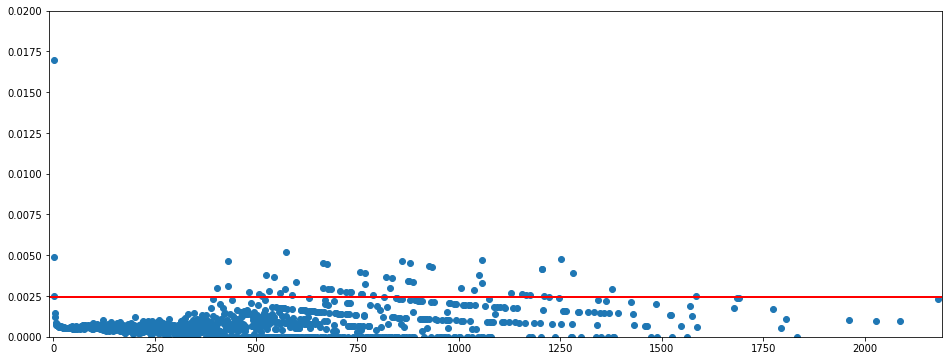

In [155]:
rate = df_agg.total_attrib.sum()/df_agg.total_click.sum()
print("overall attribution rate: ", rate)
xmax = df_agg.count_click.max()

plt.figure(figsize=(16, 6))
plt.xlim(-10, xmax + 10)
plt.ylim(0, 0.02)
plt.scatter(x=df_agg.count_click, y=df_agg.rate_attrib)
plt.axhline(y=rate, xmin=-10, xmax=xmax + 10, linewidth=2, color = 'r')

### 分間クリック数が著しく多いユーザーの観察
---
特定のip_device_osに集中している？

In [184]:
df[df.count_click > 1000].sort_values(by="ip_device_os_dow_hour_min")

,ip_device_os_dow_hour_min,count_click,count_attrib,flag_attrib,idx
21309903,73487000101322208.0,1006,1,True,1006
21309912,73487000101330000.0,1181,0,False,1181
21310017,73487000101332096.0,1037,2,True,1037
21310018,73487000101332096.0,1147,1,True,1147
21310022,73487000101332192.0,1043,1,True,1043
21310023,73487000101332192.0,1369,2,True,1369
21310024,73487000101332192.0,1200,1,True,1200
21310027,73487000101332304.0,1428,2,True,1428
21310032,73487000101340000.0,1056,0,False,1056
21310033,73487000101340000.0,1011,2,True,1011


In [222]:
df["ip_device_os"] = np.floor(df.ip_device_os_dow_hour_min.values/100000)
df_bot = df[df.count_click > 400].groupby(by="ip_device_os", as_index=False)
df_bot_agg = pd.DataFrame()
df_bot_agg["ip_device_os"] = df_bot.agg({"count_click": "sum"}).ip_device_os.values
df_bot_agg["total_click"] = df_bot.agg({"count_click": "sum"}).count_click.values
df_bot_agg["total_attrib"] = df_bot.agg({"count_attrib": "sum"}).count_attrib.values
df_bot_agg["rate_attrib"] = df_bot_agg.total_attrib / df_bot_agg.total_click
df_bot_agg.sort_values(by="total_click", ascending=False)

,ip_device_os,total_click,total_attrib,rate_attrib
17,735160001019.0,155269,246,0.001584347165242257
14,734870001019.0,152508,270,0.001770398929892202
13,734870001013.0,96139,137,0.001425020023091565
16,735160001013.0,94773,104,0.001097358952444262
77,1142760001019.0,47294,5,0.000105721656024020
76,1142760001013.0,29611,1,0.000033771233663166
11,534540001019.0,27274,3,0.000109994866906211
44,957660001019.0,24434,11,0.000450192354915282
145,2011820001019.0,22490,27,0.001200533570475767
43,957660001013.0,22077,1,0.000045296009421570


In [223]:
print(df_bot_agg[df_bot_agg.total_attrib > 0].ip_device_os.count())
print(df_bot_agg[df_bot_agg.total_attrib == 0].ip_device_os.count())

39
169
